In [27]:
!pip install scikit-learn

In [28]:
!pip install caer

In [29]:
!pip install caer canaro

In [30]:
!pip install matplotlib

In [32]:
!pip install tensorflow keras

In [27]:
import matplotlib.pyplot as plt
import os
import gc

import torch
import cv2 as cv
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import caer
import canaro

In [2]:
img_size=(180,180)
channels = 1
char_path= 'Data/simpsons_dataset'

In [3]:
char_dict={}
for char in os.listdir(char_path):
    char_dict[char]=len(os.listdir(os.path.join(char_path,char)))
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [4]:
chars = []
cnt=0
for i in char_dict:
    chars.append(i[0])
    cnt+=1
    if cnt>=10:
        break
chars

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [29]:
#Создание тренировочных данных
train=caer.preprocess_from_dir(char_path, chars, channels=channels, IMG_SIZE=img_size, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.12914657592773438s
[INFO] At 1000 files
[INFO] 1454 files found in 0.02210092544555664s
[INFO] At 1000 files
[INFO] 1452 files found in 0.07952380180358887s
[INFO] At 1000 files
[INFO] 1354 files found in 0.007006168365478516s
[INFO] At 1000 files
[INFO] 1342 files found in 0.046529531478881836s
[INFO] At 1000 files
[INFO] 1291 files found in 0.03596353530883789s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0060002803802490234s
[INFO] At 1000 files
[INFO] 1194 files found in 0.1447436809539795s
[INFO] At 1000 files
[INFO] 1193 files found in 0.006001472473144531s
[INFO] At 1000 files
[INFO] 1079 files found in 0.005000591278076172s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 36s


In [30]:
len(train)

13811

<function matplotlib.pyplot.show(close=None, block=None)>

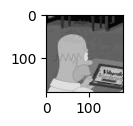

In [31]:
plt.figure(figsize=(1,1))
plt.imshow(train[0][0], cmap='gray')
plt.show

In [32]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=img_size)

In [33]:
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(chars))

In [34]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.1)

In [35]:
# x_train.shape
# y_train.shape

In [36]:
# Создаем модель нейронной сети
model = Sequential()

# Добавляем сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 1)))

# Добавляем слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# Добавляем второй сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))

# Добавляем второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# Преобразуем двумерные данные в одномерные
model.add(Flatten())

# Добавляем полносвязный слой
model.add(Dense(64, activation='relu'))

# Добавляем выходной слой
model.add(Dense(10, activation='softmax'))

# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)

# Компилируем модель
# model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Сергей Мендруль\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                  │ (None, 178, 178, 64)          │         640 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_6 (MaxPooling2D)     │ (None, 89, 89, 64)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_7 (Conv2D)                  │ (None, 87, 87, 64)            │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_7 (MaxPooling2D)     │ (None, 43, 43, 64)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_3 (Flatten)                │ (None, 118336)                │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_6 (Dense)                    │ (None, 64)                    │   7,573,568 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_7 (Dense)                    │ (None, 10)                    │         650 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 7,611,786 (29.04 MB)

 Trainable params: 7,611,786 (29.04 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
del train
del featureSet
del labels
gc.collect()

BATCH_SIZE=10
EPOCHS=25
if torch.cuda.is_available():
    print("CUDA доступно на вашем компьютере.")
else:
    print("CUDA не доступно на вашем компьютере.")

CUDA не доступно на вашем компьютере.


In [38]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1
                             , zoom_range=0.2)
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)
# len(x_train)
# len(y_val)

training=model.fit(train_gen, steps_per_epoch=len(x_train)//BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val),
                   validation_steps=len(y_val)//BATCH_SIZE, callbacks=callbacks_list)
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Epoch 1/25


C:\Users\Сергей Мендруль\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 378s 302ms/step - accuracy: 0.1599 - loss: 2.8659 - val_accuracy: 0.1562 - val_loss: 2.2664 - learning_rate: 0.0100
Epoch 2/25


C:\Users\Сергей Мендруль\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1000 - loss: 1.1377 - val_accuracy: 0.1562 - val_loss: 2.2664 - learning_rate: 0.0100
Epoch 3/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 377s 303ms/step - accuracy: 0.1648 - loss: 2.2815 - val_accuracy: 0.1562 - val_loss: 2.2650 - learning_rate: 0.0100
Epoch 4/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2000 - loss: 1.1252 - val_accuracy: 0.1562 - val_loss: 2.2650 - learning_rate: 0.0100
Epoch 5/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 373s 300ms/step - accuracy: 0.1634 - loss: 2.2838 - val_accuracy: 0.1562 - val_loss: 2.2676 - learning_rate: 0.0100
Epoch 6/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3000 - loss: 1.1137 - val_accuracy: 0.1562 - val_loss: 2.2677 - learning_rate: 0.0100
Epoch 7/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 384s 309ms/step - accuracy: 0.1671 - loss: 2.2801 - val_accuracy: 0.1562 - val_loss: 2.2649 - learning_rate: 0.0100
Epoch 8/25
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1000 - 

KeyboardInterrupt: 

In [78]:
val_datagen = canaro.generators.imageDataGenerator()
val_gen = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
model.evaluate(val_gen)

1/1 [==============================] - 0s 224ms/step - loss: 0.3769 - accuracy: 1.0000


[0.37694883346557617, 1.0]

In [96]:
img1 = cv.imread('Data/kaggle_simpson_testset/kaggle_simpson_testset/ned_flanders_12.jpg')
def prepare(image, img_size):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image = (image/10).astype('uint8')
    image = cv.resize(image, img_size)
    image = caer.reshape(image, img_size, 1)
    return image

In [97]:
img_size = (180,180)
predictions = model.predict(prepare(img1, img_size))

1/1 [==============================] - 0s 37ms/step


In [98]:
print(chars[np.argmax(predictions[0])])

homer_simpson
